# load img2label dataset

In [1]:
%install-location $cwd/swift-install
%install-swiftpm-flags -c release
// %install '.package(url: "https://github.com/tensorflow/swift-models", .branch("tensorflow-0.8"))' Batcher ModelSupport Datasets
%install '.package(path: "/notebooks/language2motion.gt/code")' Batcher ModelSupport Datasets ImageClassificationModels

Installing packages:
	.package(path: "/notebooks/language2motion.gt/code")
		Batcher
		ModelSupport
		Datasets
		ImageClassificationModels
With SwiftPM flags: ['-c', 'release']
Working in: /tmp/tmp5csvrusw/swift-install
Fetching https://github.com/apple/swift-protobuf.git
Cloning https://github.com/apple/swift-protobuf.git
Resolving https://github.com/apple/swift-protobuf.git at 1.8.0
[1/6] Compiling STBImage stb_image_write.c
[2/6] Compiling Batcher Backend.swift
[3/6] Compiling STBImage stb_image.c
[4/6] Compiling SwiftProtobuf AnyMessageStorage.swift
/notebooks/language2motion.gt/code/Sources/ResNet-img2label/swift-install/package/.build/checkouts/swift-protobuf/Sources/SwiftProtobuf/BinaryDelimited.swift:198:7: warning: variable 'readBuffer' was never mutated; consider changing to 'let' constant
  var readBuffer = UnsafeMutablePointer<UInt8>.allocate(capacity: 1)
  ~~~ ^
  let
[5/7] Compiling ImageClassificationModels DenseNet121.swift
[6/7] Compiling ModelSupport BijectiveDictiona

: 

In [2]:
import Foundation
import PythonKit
import TensorFlow

import Batcher
import ModelSupport
import Datasets

import ImageClassificationModels

In [7]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let plt = Python.import("matplotlib.pyplot")
let np  = Python.import("numpy")
let random  = Python.import("random")
let sklearn  = Python.import("sklearn")
let model_selection  = Python.import("sklearn.model_selection")
let subprocess = Python.import("subprocess")
let glob = Python.import("glob")
let pil = Python.import("PIL")
let Image = Python.import("PIL.Image")

In [4]:
// TODO:
// - download dataset if not present
// - unpack dataset

## load image

In [5]:
let im65URL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/img2label_ds_v1/Doing something/00065.png")

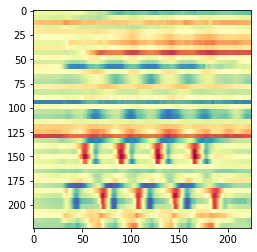

None


In [8]:
let img = Image.open(im65URL.path)
plt.imshow(img)
plt.show()

## enumerate images

In [ ]:
/// load the image and extract the label
/// from Swift4TF_TransferLearning.ipynb
func getTensorLabel(_ imageURL: URL, labels: [String]) -> (Tensor<Float>, Int32){
  
    let label: Int32
  
    let labelStr = imageURL.deletingLastPathComponent().lastPathComponent
    label = Int32(labels.index(of: labelStr)!)
  
    let img = pil.Image.open(imageURL.path)
    let arr = np.array(img)[0..<224, 0..<224, 0..<3] // kill transparency
    let image = Tensor<UInt8>(numpy: arr)!

    var tensor = Tensor<Float>(image)
    tensor = Raw.expandDims(tensor, dim: Tensor<Int32>(0))
    tensor = Raw.resizeArea(images:tensor, size:[224, 224])
    return (tensor.squeezingShape(at: 0), label)
}

// let (tensor, label) = getTensorLabel(URL(fileURLWithPath: im65URL.path), labels: labels)
// tensor.shape

In [ ]:
func loadImages(imageList: [String], labels: [String], normalizing: Bool = true) -> [TensorPair<Float, Int32>] {
    let tensorLabels = imageList.map {
        getTensorLabel(URL(fileURLWithPath: $0), labels: labels)
    }
    
    let imageCount = tensorLabels.count
    let labelTensor = Tensor<Int64>(shape: [imageCount], scalars: tensorLabels.map {Int64($0.1)})

    var imageTensor = Tensor<Float>(stacking: tensorLabels.map {$0.0}, alongAxis: 0)

    // The value of mean and std were calculated with the following Swift code:
    // ```
    // import TensorFlow
    // import Datasets
    // import Foundation

    // let dsURL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/img2label_ds_v1", isDirectory: true)
    // let dataset = Img2Label(batchSize: 2500, dsURL: dsURL, normalizing: false)
    // print("dataset.training.count: \(dataset.training.count)")
    // for batch in dataset.training.sequenced() {
    //     let images = Tensor<Double>(batch.first) / 255.0
    //     let mom = images.moments(squeezingAxes: [0,1,2])
    //     print("mean: \(mom.mean) std: \(sqrt(mom.variance))")
    // }
    // ```
    if normalizing {
        let mean = Tensor<Float>(
                [0.8836673330105219,
                 0.8571306618582774,
                 0.5989467475049005])
        let std = Tensor<Float>(
                [0.1870305997172803,
                 0.1698038429051249,
                 0.11811759458558127])
        imageTensor = ((imageTensor / 255.0) - mean) / std
    }
    
    return (0..<imageCount).map { TensorPair(first: imageTensor[$0], second: Tensor<Int32>(labelTensor[$0])) }
        
}

In [ ]:
public struct Img2Label: ImageClassificationDataset {
    public typealias SourceDataSet = [TensorPair<Float, Int32>]
    public let training: Batcher<SourceDataSet>
    public let test: Batcher<SourceDataSet>
    public let labels: [String]

    public init(batchSize: Int) {
        let dsURL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/img2label_ds_v1", isDirectory: true)
        self.init(batchSize: batchSize, dsURL: dsURL)
    }

    public init(batchSize: Int, dsURL: URL, normalizing: Bool = true) {
        let labels2: [String] = Img2Label.loadLabels(dsURL)
        
        let imageList = glob.glob(dsURL.path + "/**/*.png")
        let (trainPythonList, testPythonList) = model_selection.train_test_split(imageList, test_size: 0.2).tuple2
        let (trainList, testList): ([String], [String]) = (Array(trainPythonList)!.sorted(), Array(testPythonList)!.sorted())
        
        let trainTensorPairs = loadImages(imageList: trainList, labels: labels2, normalizing: normalizing)
        print("trainTensorPairs.count = \(trainTensorPairs.count)")
        let testTensorPairs = loadImages(imageList: testList, labels: labels2, normalizing: normalizing)
        print("testTensorPairs.count = \(testTensorPairs.count)")
        self.training = Batcher(
            on: trainTensorPairs,
            batchSize: batchSize,
            numWorkers: 1, //No need to use parallelism since everything is loaded in memory
            shuffle: true)
        self.test = Batcher(
            on: testTensorPairs,
            batchSize: batchSize,
            numWorkers: 1,
            shuffle: true)
        self.labels = labels2
    }
    
    static func loadLabels(_ dsURL: URL) -> [String] {
        let fm = FileManager()
        let labels = try! fm.contentsOfDirectory(atPath: dsURL.path).filter({ !$0.hasPrefix(".") }).sorted()
        return labels
    }
}

In [ ]:
let batchSize = 25

let dsURL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/img2label_ds_v1", isDirectory: true)

let dataset = Img2Label(batchSize: batchSize, dsURL: dsURL, normalizing: true)
print("dataset.training.count: \(dataset.training.count)")
print("dataset.test.count: \(dataset.test.count)")

## training

In [ ]:
// Use the network sized for CIFAR-10
var model = ResNet(classCount: 5, depth: .resNet56, downsamplingInFirstStage: false)

// the classic ImageNet optimizer setting diverges on CIFAR-10
// let optimizer = SGD(for: model, learningRate: 0.1, momentum: 0.9)
let optimizer = SGD(for: model, learningRate: 0.001)

In [ ]:
print("Starting img2label training...")

for epoch in 1...10 {
    print("epoch \(epoch)")
    Context.local.learningPhase = .training
    var trainingLossSum: Float = 0
    var trainingBatchCount = 0
    for batch in dataset.training.sequenced() {
        print("progress \(100.0*Float(trainingBatchCount)/Float(dataset.training.count))%")
        let (images, labels) = (batch.first, batch.second)
        let (loss, gradients) = valueWithGradient(at: model) { model -> Tensor<Float> in
            let logits = model(images)
            return softmaxCrossEntropy(logits: logits, labels: labels)
        }
        trainingLossSum += loss.scalarized()
        trainingBatchCount += 1
        optimizer.update(&model, along: gradients)
    }

    Context.local.learningPhase = .inference
    var testLossSum: Float = 0
    var testBatchCount = 0
    var correctGuessCount = 0
    var totalGuessCount = 0
    for batch in dataset.test.sequenced() {
        print("batch")
        let (images, labels) = (batch.first, batch.second)
        let logits = model(images)
        testLossSum += softmaxCrossEntropy(logits: logits, labels: labels).scalarized()
        testBatchCount += 1

        let correctPredictions = logits.argmax(squeezingAxis: 1) .== labels
        correctGuessCount = correctGuessCount
            + Int(
                Tensor<Int32>(correctPredictions).sum().scalarized())
        totalGuessCount = totalGuessCount + batchSize
    }

    let accuracy = Float(correctGuessCount) / Float(totalGuessCount)
    print(
        """
        [Epoch \(epoch)] \
        Accuracy: \(correctGuessCount)/\(totalGuessCount) (\(accuracy)) \
        Loss: \(testLossSum / Float(testBatchCount))
        """
    )
}

In [ ]:
// import TensorFlow
// import Datasets
// import Foundation

// let dsURL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/img2label_ds_v1", isDirectory: true)
// let dataset = Img2Label(batchSize: 2500, dsURL: dsURL, normalizing: false)
// print("dataset.training.count: \(dataset.training.count)")
// for batch in dataset.training.sequenced() {
//     let images = Tensor<Double>(batch.first) / 255.0
//     let mom = images.moments(squeezingAxes: [0,1,2])
//     print("mean: \(mom.mean) std: \(sqrt(mom.variance))")
// }